<a href="https://colab.research.google.com/github/si-mong/AI_lab/blob/main/AI_week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Audio Feature Extractions
##Overview of audio features
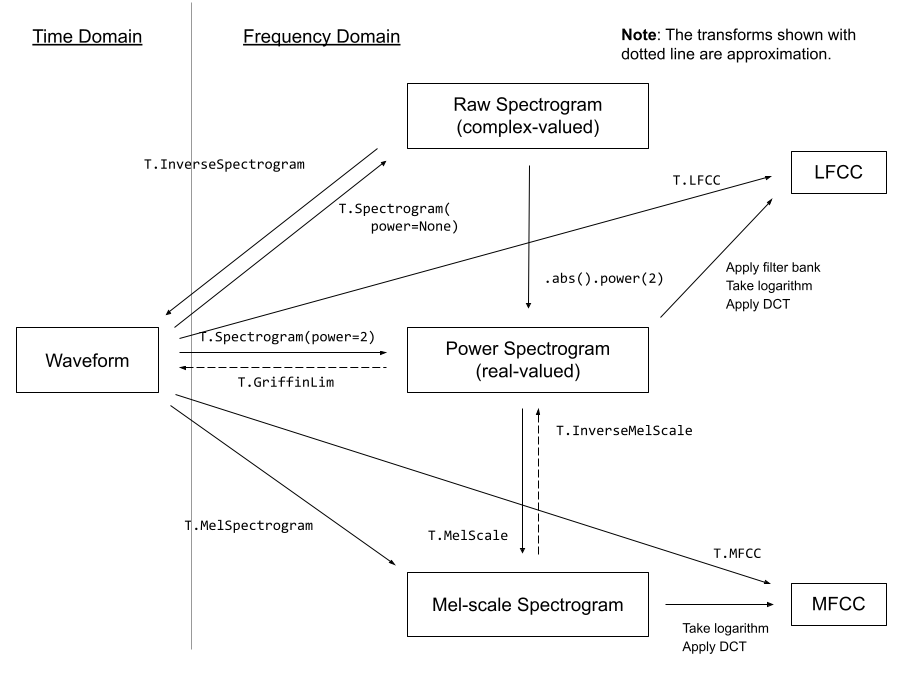

- **1단계: 웨이브폼 (Waveform) 준비**
  - 모든 분석은 원본 오디오 파일인 웨이브폼에서 시작한다. 이것은 시간의 흐름에 따른 소리의 진폭을 나타내는 시간 영역(Time Domain) 데이터이다.
- **2단계: 스펙트로그램 (Spectrogram) 변환**
  - 웨이브폼을 푸리에 변환(Fourier Transform)과 같은 기법을 사용해 **주파수 영역(Frequency Domain)** 으로 변환한다. 이렇게 생성된 **스펙트로그램(Spectrogram)** 은 시간에 따라 어떤 주파수 성분이 얼마나 강한지를 보여주는 '소리의 지도' 역할을 한다.

- **3단계: 멜 스케일 (Mel-scale) 적용**
  - 사람의 귀가 저주파에 더 민감한 특성을 모방하기 위해, 스펙트로그램의 주파수 축을 멜 스케일로 조정한다. 이 과정을 거치면 **멜 스케일 스펙트로그램(Mel-scale Spectrogram)** 이 만들어진다. 이는 기계가 사람처럼 소리의 특징을 인식하도록 돕는 핵심 과정이다.

- **4단계: MFCC (최종 특징) 추출**
  - 마지막으로, 멜 스케일 스펙트로그램에 로그(log)를 취하고 DCT(이산 코사인 변환)를 적용하여 데이터의 차원을 줄이고 핵심 정보만 압축한다. 이 결과물이 바로 음성 인식 모델의 입력으로 주로 사용되는 최종 특징인 **MFCC(Mel-Frequency Cepstral Coefficients)** 이다. 이 과정을 통해 소리의 중요한 특징만 간결하게 요약한다.

In [72]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

2.8.0+cu126
2.8.0+cu126


In [73]:
!pip install librosa

In [74]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("/content/sample_data/audio_week4.m4a")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

/tmp/ipython-input-2826744528.py:7: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_SPEECH = download_asset("/content/sample_data/audio_week4.m4a")


##Spectogram
###n_fft 파라미터의 효과

In [75]:
# Load audio
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load("/content/sample_data/audio_week4.m4a")

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

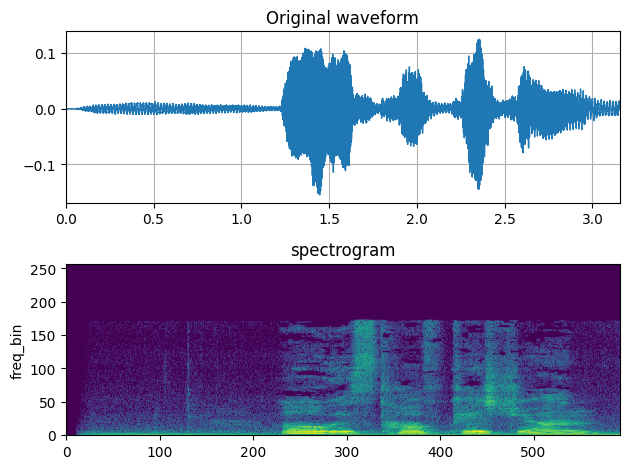

In [76]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()




---


###n_fft 파라미터의 역할: 주파수 분석의 정밀도
n_fft는 **'Fast Fourier Transform(FFT)'**의 약자로, 푸리에 변환을 얼마나 잘게 쪼개서 분석할 것인지를 결정하는 분해능(resolution) 파라미터이다.

- FFT(고속 푸리에 변환): 소리 신호(Waveform)를 여러 주파수 성분의 합으로 분해하는 수학적 과정이다.

- n_fft의 역할:

  - 소리를 아주 짧은 구간(프레임)으로 나눈 뒤, 각 구간을 FFT로 변환한다.

  - n_fft는 이 변환을 할 때 사용할 샘플의 개수를 의미한다. 이 값을 **'FFT 사이즈'**라고도 부른다.

  - n_fft 값이 크면 주파수 축을 더 세밀하게 분석할 수 있어 주파수 해상도가 높아진다. 대신 시간 해상도는 약간 떨어진다.

  - n_fft 값이 작으면 시간 축의 변화는 더 잘 포착하지만 주파수 해상도는 낮아진다.

간단히 말해, n_fft는 스펙트로그램의 세로축(주파수 축)을 얼마나 촘촘하게 그릴지 결정하는 값이다.


---



In [77]:
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

In [78]:
n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(SPEECH_WAVEFORM)
    specs.append(spec)

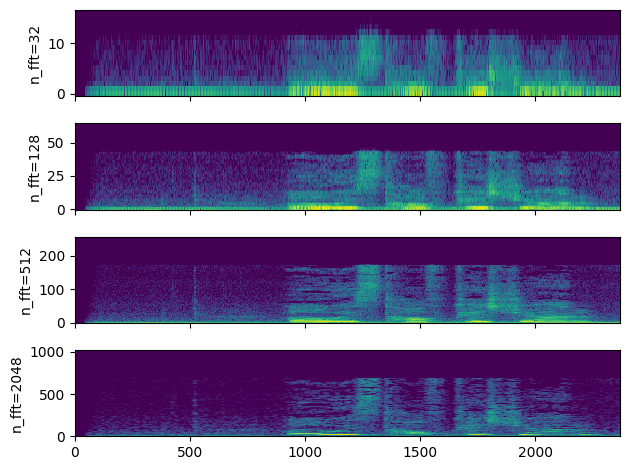

In [79]:
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

In [80]:
# Downsample to half of the original sample rate
speech2 = torchaudio.functional.resample(SPEECH_WAVEFORM, SAMPLE_RATE, SAMPLE_RATE // 2)
# Upsample to the original sample rate
speech3 = torchaudio.functional.resample(speech2, SAMPLE_RATE // 2, SAMPLE_RATE)

# Apply the same spectrogram
spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(SPEECH_WAVEFORM)
spec2 = spectrogram(speech2)
spec3 = spectrogram(speech3)



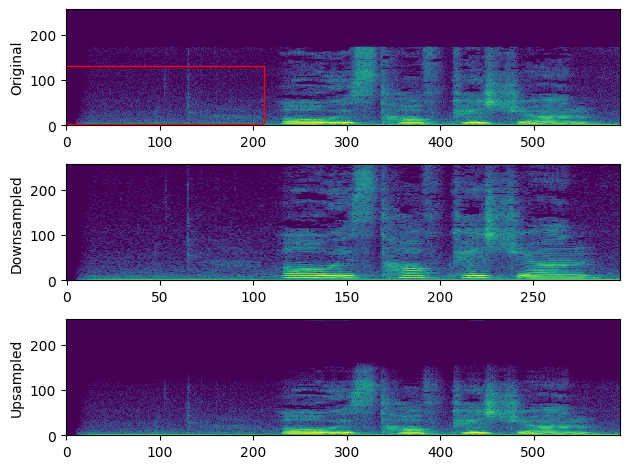

In [81]:
# Visualize it
fig, axs = plt.subplots(3, 1)
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0, 3), 212, 128, edgecolor="r", facecolor="none"))
plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])
plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])
fig.tight_layout()

---
##GriffinLim

Griffin-Lim은 스펙트로그램(Spectrogram) 이미지로부터 원본 오디오(Waveform)를 복원할 때 사용하는 알고리즘이다.

- **문제 상황** : 스펙트로그램은 소리의 '주파수'와 '세기(magnitude)' 정보만 담고 있다. 하지만 오디오를 완벽하게 복원하려면 **'위상(phase)'**이라는 정보가 추가로 필요하다. 보통 스펙트로그램을 만들 때 이 위상 정보는 버려진다.

- **Griffin-Lim의 역할** : 손실된 위상 정보를 반복적인 계산을 통해 추측하고 복원해내는 역할을 한다.

  1. 처음에는 임의의 위상 값으로 시작하여 오디오 신호를 복원한다.

  2. 복원된 신호로 다시 스펙트로그램을 만든다.

  3. 만들어진 스펙트로그램의 '세기'를 원본 스펙트로그램의 '세기'와 최대한 비슷하게 맞춰준다.

  4. 이 과정을 여러 번 반복하면, 점점 원본과 유사한 위상 값을 가진 오디오가 복원된다.

노트북의 torchaudio.transforms.GriffinLim은 이 복잡한 과정을 수행하여, MFCC나 멜 스펙트로그램 같은 특징으로부터 다시 음성 파일을 생성할 수 있게 해준다.



In [82]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(SPEECH_WAVEFORM)
reconstructed_waveform = griffin_lim(spec)

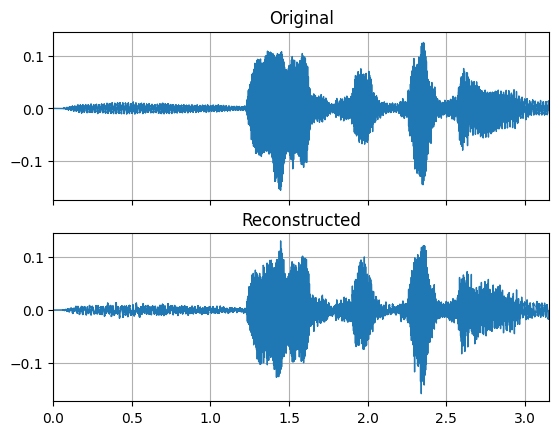

In [83]:
_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed", ax=axes[1])
Audio(reconstructed_waveform, rate=SAMPLE_RATE)

---
##Mel Filter Bank
Mel Filter Bank는 일반 스펙트로그램을 멜 스펙트로그램으로 변환하는 데 사용되는 필터들의 집합이다.

- 목표: 사람이 소리를 인식하는 방식(저주파에 민감, 고주파에 둔감)을 모방하는 것이다.

- 작동 방식:

  - '필터 뱅크'는 여러 개의 삼각형 모양 필터로 구성되어 있다.

  - 이 필터들은 저주파 영역에서는 좁고 촘촘하게, 고주파 영역에서는 넓고 듬성듬성하게 배치되어 있다.

  - 일반 스펙트로그램에 이 필터 뱅크를 통과(적용)시키면, 각 필터는 해당 주파수 대역의 에너지를 하나로 합쳐서 대표값으로 만든다.

결과적으로, 선형적(linear)이었던 주파수 축이 사람이 듣는 방식과 유사한 멜 스케일(Mel scale) 축으로 압축 및 변환된다. 이것이 바로 멜 스펙트로그램이다. 코드에서의 torchaudio.transforms.MelSpectrogram 내부에서 이 멜 필터 뱅크가 핵심적인 역할을 수행한다.

---

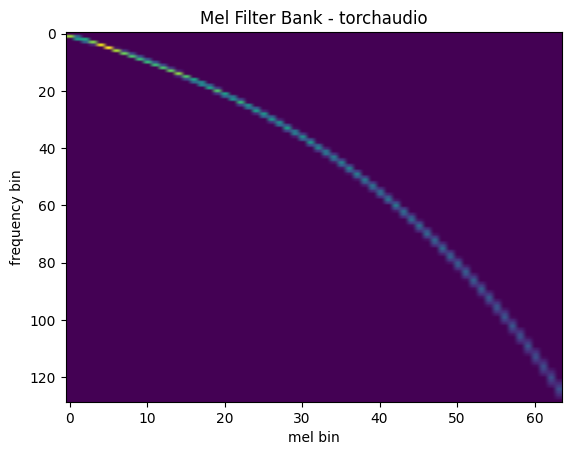

In [84]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

###Comparison against librosa

/tmp/ipython-input-3559595193.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.square(mel_filters - mel_filters_librosa).mean().item()


Mean Square Difference:  3.934872696751886e-17


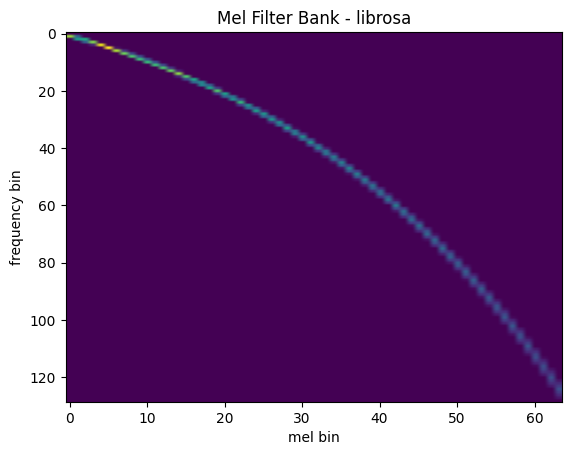

In [85]:
mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)

---
##MelSpectrogram
멜 스펙트로그램 (Mel Spectrogram): 사람처럼 듣기
일반 스펙트로그램은 주파수를 선형적으로 분석하지만, 사람은 저주파 대역의 변화에 더 민감하게 반응한다. 멜 스펙트로그램은 이러한 사람의 청각 특성을 반영한 스펙트로그램이다.

- 멜 스케일(Mel Scale): 사람이 인지하는 소리의 높낮이를 기준으로 만든 비선형적 주파수 척도이다. 저주파 대역은 촘촘하게, 고주파 대역은 넓게 분석하도록 설계되었다.

- 변환 과정: 일반 스펙트로그램에 '멜 필터뱅크(Mel Filterbank)'를 적용하여 주파수 축을 멜 스케일로 변환 및 압축한다.

- 장점: 기계가 사람의 목소리와 같이 중요한 정보가 집중된 저주파 대역에 더 집중하게 만들어 모델의 성능을 향상시킨다.

다음 코드에서는 torchaudio.transforms.MelSpectrogram을 사용해 멜 스펙트로그램을 생성하고, 일반 스펙트로그램과 주파수 축이 어떻게 다르게 표현되는지 비교하여 보여준다.

---

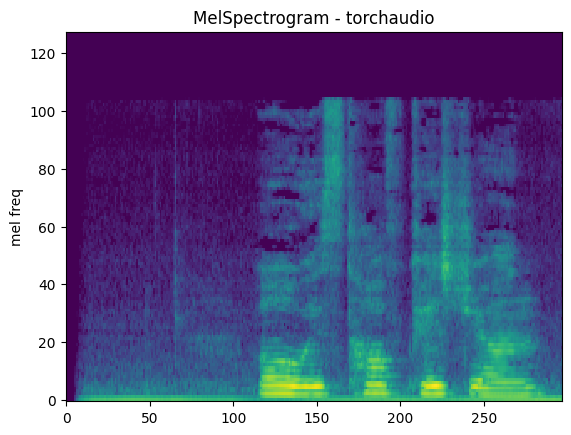

In [86]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

###Comparison against librosa


/tmp/ipython-input-971624474.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.square(melspec - melspec_librosa).mean().item()


Mean Square Difference:  7.24992982314987e-12


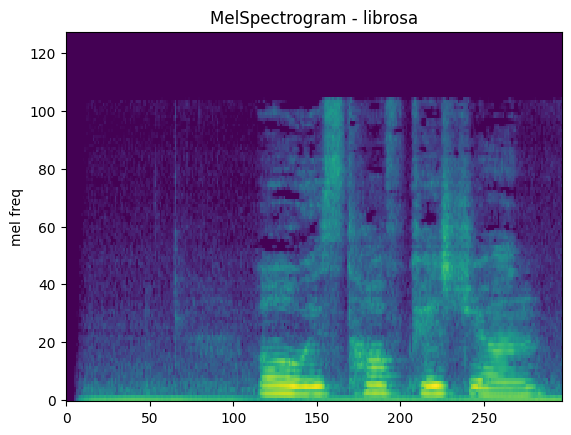

In [87]:
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

---
##MFCC
MFCC (Mel-Frequency Cepstral Coefficients):
핵심만 남기기  
멜 스펙트로그램은 여전히 많은 정보를 포함하며 각 주파수 대역 간 연관성이 높다. MFCC는 여기서 한 단계 더 나아가 정보를 압축하고 핵심적인 특징만을 추출하는 마지막 단계이다.

- 변환 과정:멜 스펙트로그램 값에 로그(log)를 적용한다.

- 여기에 '이산 코사인 변환(DCT)'을 적용하여 정보의 핵심 성분만 요약하고 차원을 축소한다.

- 결과물: 각 시간대별 소리의 특징을 나타내는 작은 크기의 숫자 벡터(계수 집합)가 된다. MFCC는 음성의 고유한 특성을 매우 효율적으로 표현한다.

다음 코드에서는 torchaudio.transforms.MFCC를 통해 최종 MFCC를 계산하고, 이를 이미지 형태로 시각화한다. 이 MFCC가 바로 **Speech recognition**와 같은 음성 인식 모델에 입력으로 사용될 최종 '재료'가 된다.

---

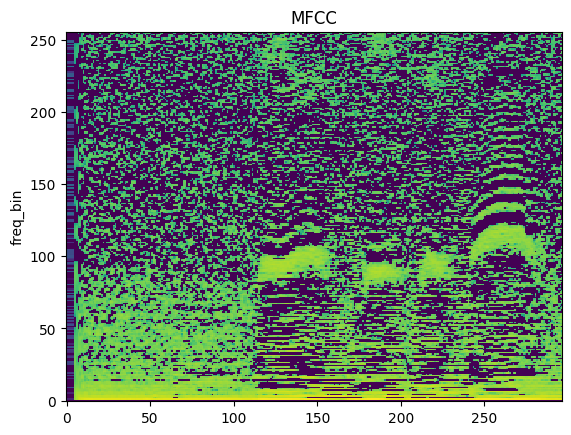

In [88]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

plot_spectrogram(mfcc[0], title="MFCC")

###Comparison against librosa


/tmp/ipython-input-4136575261.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.square(mfcc - mfcc_librosa).mean().item()


Mean Square Difference:  0.02738332562148571


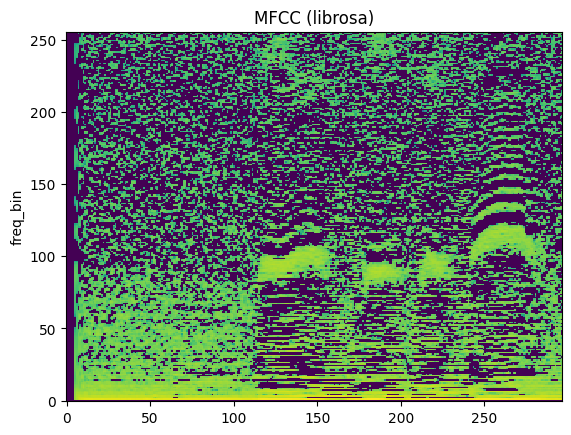

In [89]:
melspec = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

mfcc_librosa = librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho",
)

plot_spectrogram(mfcc_librosa, title="MFCC (librosa)")

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print("Mean Square Difference: ", mse)

##LFCC
**LFCC** 는 MFCC와 매우 유사한 오디오 특징이지만, 주파수를 분석하는 척도(scale)에서 결정적인 차이를 보인다.

- MFCC와의 차이점: MFCC가 사람의 청각 특성을 모방한 **멜 스케일(Mel Scale)** 을 사용하는 반면, LFCC는 주파수를 **선형 스케일(Linear Scale)** 로 분석한다. 즉, 100Hz, 200Hz, 300Hz처럼 모든 주파수 대역을 동일한 간격과 중요도로 취급한다.

- 생성 과정:

  1. 오디오 신호를 스펙트로그램으로 변환한다.

  2. 이 스펙트럼에 로그(log)를 적용한다. (멜 필터 뱅크를 적용하지 않는다.)

  3. 마지막으로 DCT(이산 코사인 변환)를 적용하여 특징을 압축 및 요약한다.

- 주요 용도: LFCC는 사람의 목소리가 아닌 기계가 합성한 소리나 미세한 노이즈 등을 탐지하는 데 효과적일 수 있다. 이 때문에 실제 목소리와 가짜 목소리를 구별하는 **음성 위변조 방지(Anti-spoofing)** 나 화자 인증(Speaker Verification) 분야에서 종종 사용된다.

간단히 말해, LFCC는 사람의 청각 특성을 의도적으로 배제하고 순수 물리적인 관점에서 주파수를 분석한 특징이다.



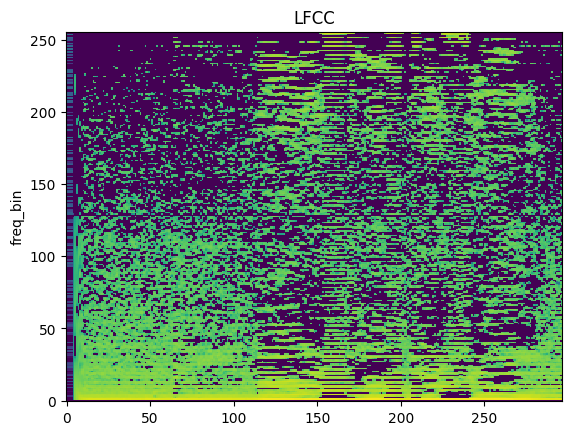

In [90]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM)
plot_spectrogram(lfcc[0], title="LFCC")

##Pitch (음고, 音高)
**Pitch** 는 우리가 소리를 들을 때 느끼는 **'음의 높낮이'** 를 의미한다. 이는 소리를 발생시키는 음원(성대 등)이 1초에 얼마나 빠르게 진동하는지에 따라 결정되는 **기본 주파수(Fundamental Frequency, f0)** 와 직접적인 관련이 있다.

- **특징** :

  - 진동이 빠르면(주파수가 높으면) 높은 소리(고음)로 인식한다.

  - 진동이 느리면(주파수가 낮으면) 낮은 소리(저음)로 인식한다.

- **음성에서의 역할** : Pitch는 말의 억양(Intonation)을 만드는 핵심 요소이다. 예를 들어, 문장의 끝을 올리면(Pitch 상승) 의문문이 되고, 끝을 내리면(Pitch 하강) 평서문이 된다. 또한 감정 상태를 전달하는 데도 중요한 역할을 한다.

- **추출 방법**: 오디오 파형에서 Pitch 정보를 추출하기 위해 YIN, pYIN, CREPE와 같은 다양한 알고리즘이 사용된다.

Pitch는 소리의 멜로디나 억양과 관련된 특징을 분석할 때 가장 기본적이고 중요한 정보이다.

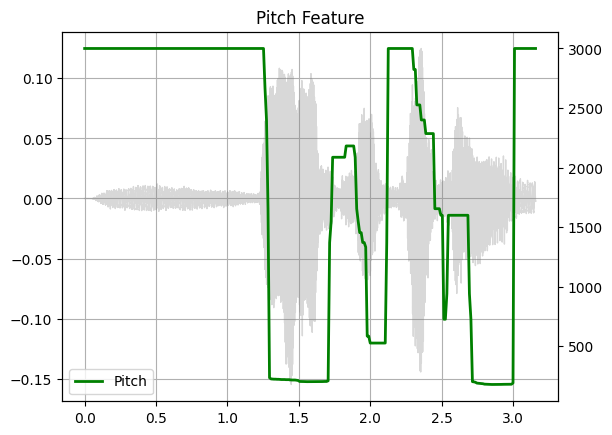

In [91]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM, SAMPLE_RATE)


def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)


plot_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch)

#Speech Recognition with Wav2Vec2
##용어정리
- **파형(waveform):**
  - 소리를 디지털로 기록한 1차원 신호. 시간에 따라 공기의 압력(진폭)이 어떻게 변하는지를 숫자로 표현한 것.
  - → x축: 시간, y축: 진폭(진동 크기).

- **샘플레이트(sample rate, Hz):**
  - 1초 동안 몇 개의 샘플(값)을 기록했는지 나타냅니다.
  - 예)
    - CD 음질: 44,100Hz (1초당 44,100개 숫자)
    - 음성 인식 모델: 16,000Hz (1초당 16,000개 숫자)

- **채널(channel):**

  - 모노(mono): 1개의 채널. (한쪽 귀로 듣는 소리)

  - 스테레오(stereo): 2개의 채널. (왼쪽/오른쪽 귀 구분)

  - 음성 인식 모델은 모노 신호(1차원) 로 학습된 경우가 대부분 → 그래서 스테레오 파일이면 두 채널을 평균 내어 하나로 만듦.

In [92]:
print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.8.0+cu126
2.8.0+cu126
cuda


In [93]:
import IPython
import matplotlib.pyplot as plt
# from torchaudio.utils import download_asset

# SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SPEECH_FILE = "/content/sample_data/audio_week4.m4a"

##Creating a pipeline

In [94]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [95]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [96]:
!apt update && apt install -y ffmpeg

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [5,899 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,580 kB]
Get:14 http://archive.ubun

##Loading data

In [97]:
IPython.display.Audio(SPEECH_FILE) # Removed problematic line
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
IPython.display.Audio(waveform.cpu().squeeze(), rate=sample_rate)

In [98]:
waveform, sample_rate = torchaudio.load("/content/sample_data/audio_week4.m4a")
# waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [99]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

#Extracting acoustic features
1. **세로축 (Frame / Time-axis)**

  - 입력 오디오를 작은 구간(프레임) 단위로 나눈다/

  - 예: 16kHz 오디오를 20ms 윈도우로 쪼개면, 1초에 약 50프레임.

  - cf) 모델 전처리 과정에서 stride(간격) 때문에 더 줄어들기도 한다.

    - 따라서 세로축 = 시간 축(프레임 단위)
    - → 즉, 발화가 진행되면서 각 시점별로 특징 벡터가 어떻게 바뀌는지 확인

2. **가로축 (Feature dimension)**

- Transformer가 출력하는 특징 벡터의 차원입니다.

  - 예: Wav2Vec2는 hidden size = 768, HuBERT base도 768, large 모델은 1024 이상.

  - 그러면 가로축은 0~767(또는 0~1023) 이런 식의 "특징 차원 인덱스"가 된다.

  - 이 차원 각각은 사람이 직접 의미를 이해하기 어렵지만, 모델 내부적으로는 "발음 특징", "주파수 패턴", "언어적 힌트" 같은 정보를 담고다.

3. **색깔 (Color)**

- 특정 시점(frame)에서 특정 feature dimension이 얼마나 크게 활성화됐는지 (값의 크기).

- 보통 이건 hidden state 값의 크기(activation strength) 를 보여주는 heatmap.

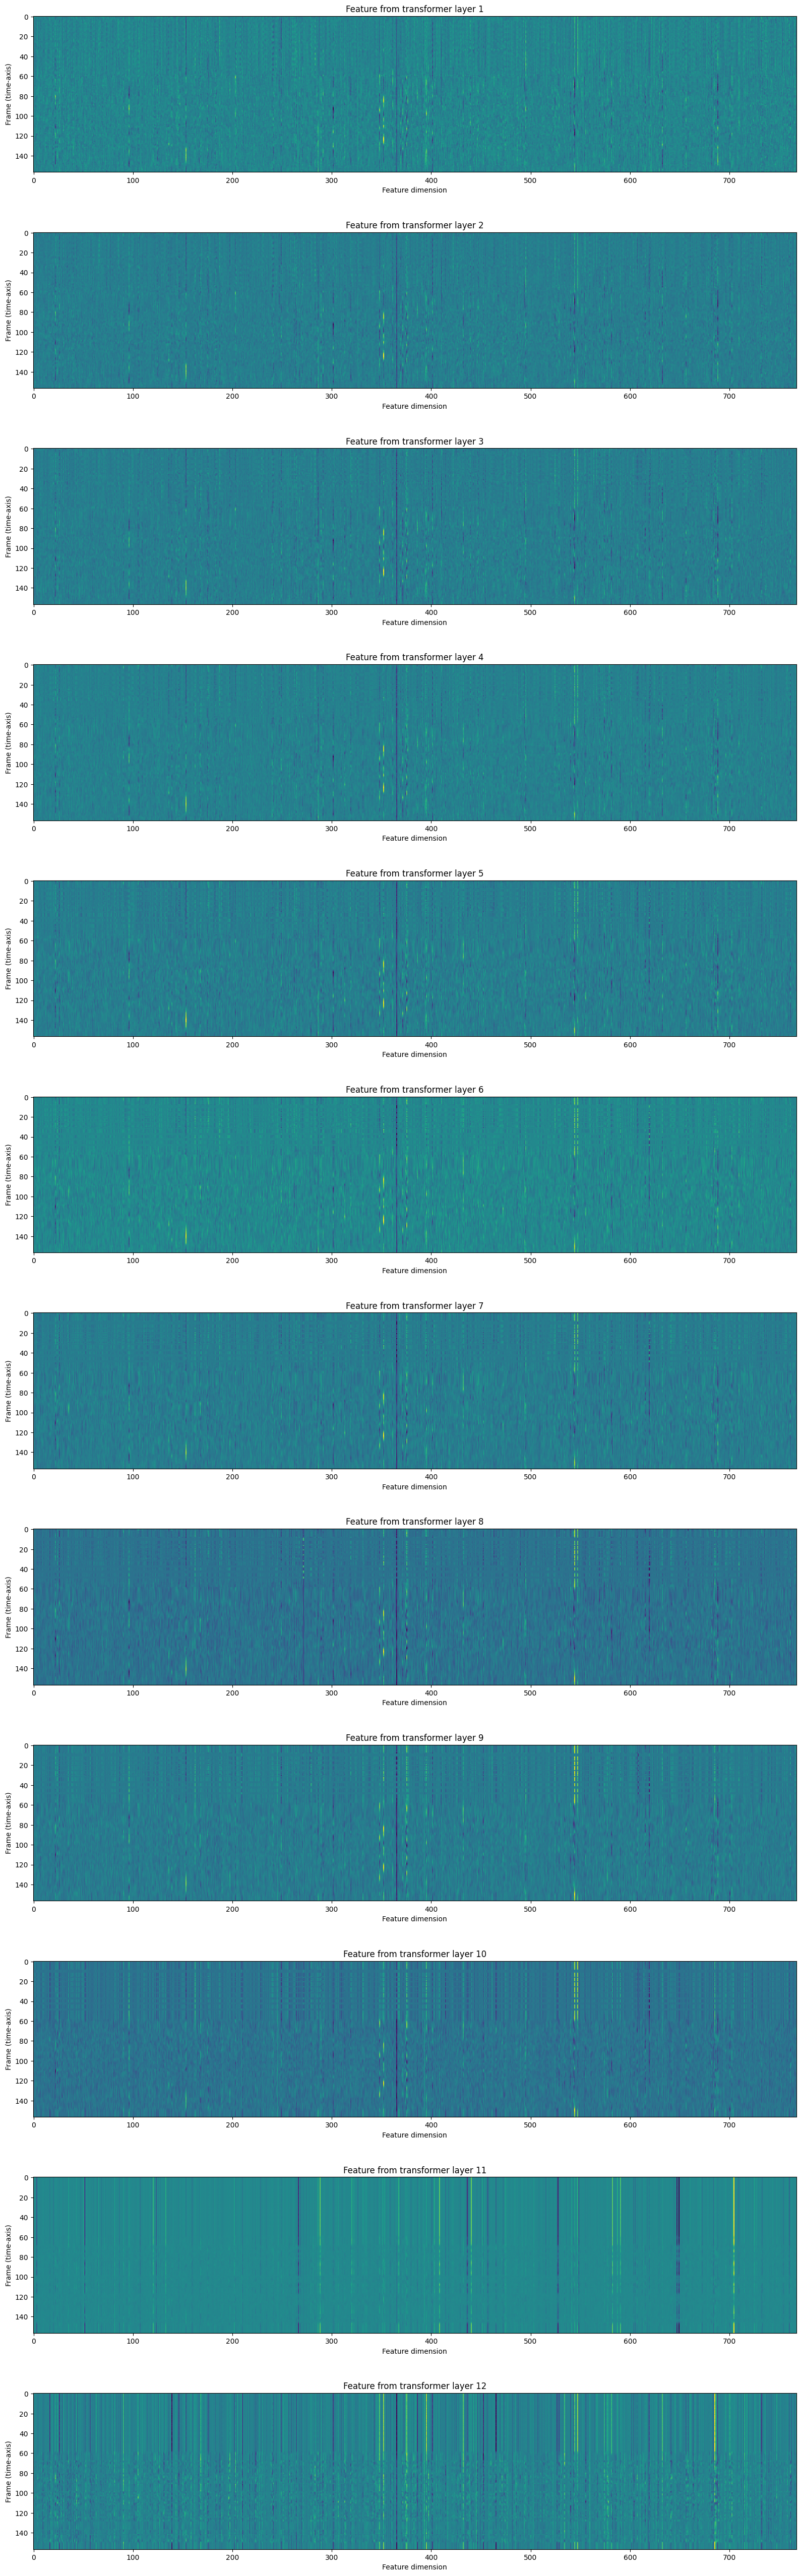

In [100]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

##Feature classification

In [101]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


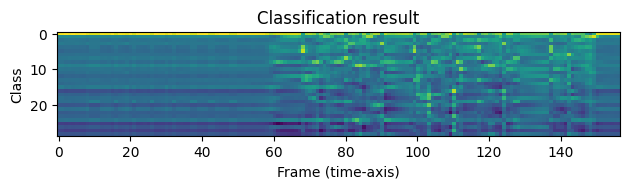

In [102]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [103]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [104]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [105]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

OH|IS|TOPH|CHRASTIAN|
